In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-16 18:07:57.274233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 18:08:00.450790: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-16 18:08:00.450960: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

2.11.0


In [2]:
# !git clone https://github.com/EricMartinezIllamola/asl-alphabet.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "asl-alphabet/asl-alphabet"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.6, 0.2, 0.2))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
tf.config.experimental.list_physical_devices()

2023-09-16 18:08:04.825972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 18:08:04.840826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 18:08:04.843592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 64 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 44695 images belonging to 24 classes.
Found 14892 images belonging to 24 classes.
Found 14921 images belonging to 24 classes.


In [10]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-16 18:08:11.658991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 18:08:11.660631: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 18:08:11.666513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 18:08:11.671799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
##DEFINIMOS EL MODELO
num_classes = 24
epochs = 125

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [12]:
## EJECUCION DEL MODELO
# with tf.device("/CPU:0"):
# with tf.device("/GPU:0"):
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-03', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/125


2023-09-16 18:08:17.755838: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-09-16 18:08:20.199763: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55cb3bb3a030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-16 18:08:20.199814: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-09-16 18:08:20.282173: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


699/699 [==============================] - ETA: 0s - loss: 7.8366 - accuracy: 0.1751
Epoch 1: accuracy improved from -inf to 0.17514, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 97s 130ms/step - loss: 7.8366 - accuracy: 0.1751 - lr: 0.0010
Epoch 2/125
699/699 [==============================] - ETA: 0s - loss: 6.2728 - accuracy: 0.5768
Epoch 2: accuracy improved from 0.17514 to 0.57682, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 90s 128ms/step - loss: 6.2728 - accuracy: 0.5768 - lr: 0.0010
Epoch 3/125
699/699 [==============================] - ETA: 0s - loss: 5.5779 - accuracy: 0.7491
Epoch 3: accuracy improved from 0.57682 to 0.74914, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 90s 128ms/step - loss: 5.5779 - accuracy: 0.7491 - lr: 0.0010
Epoch 4/125
699/699 [==============================] - ETA: 0s - loss: 5.2438 - accuracy: 0.8105
Epoch 4: accuracy improved from 0.74914 to 0.81054, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 91s 130ms/step - loss: 5.2438 - accuracy: 0.8105 - lr: 0.0010
Epoch 5/125
699/699 [==============================] - ETA: 0s - loss: 4.9957 - accuracy: 0.8493
Epoch 5: accuracy improved from 0.81054 to 0.84931, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 90s 128ms/step - loss: 4.9957 - accuracy: 0.8493 - lr: 0.0010
Epoch 6/125
699/699 [==============================] - ETA: 0s - loss: 4.7959 - accuracy: 0.8718
Epoch 6: accuracy improved from 0.84931 to 0.87180, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 90s 129ms/step - loss: 4.7959 - accuracy: 0.8718 - lr: 0.0010
Epoch 7/125
699/699 [==============================] - ETA: 0s - loss: 4.6279 - accuracy: 0.8858
Epoch 7: accuracy improved from 0.87180 to 0.88578, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 91s 129ms/step - loss: 4.6279 - accuracy: 0.8858 - lr: 0.0010
Epoch 8/125
699/699 [==============================] - ETA: 0s - loss: 4.4720 - accuracy: 0.8986
Epoch 8: accuracy improved from 0.88578 to 0.89862, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 128ms/step - loss: 4.4720 - accuracy: 0.8986 - lr: 0.0010
Epoch 9/125
699/699 [==============================] - ETA: 0s - loss: 4.3350 - accuracy: 0.9070
Epoch 9: accuracy improved from 0.89862 to 0.90701, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 4.3350 - accuracy: 0.9070 - lr: 0.0010
Epoch 10/125
699/699 [==============================] - ETA: 0s - loss: 4.2013 - accuracy: 0.9147
Epoch 10: accuracy improved from 0.90701 to 0.91469, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 90s 129ms/step - loss: 4.2013 - accuracy: 0.9147 - lr: 0.0010
Epoch 11/125
699/699 [==============================] - ETA: 0s - loss: 4.0690 - accuracy: 0.9219
Epoch 11: accuracy improved from 0.91469 to 0.92194, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 4.0690 - accuracy: 0.9219 - lr: 0.0010
Epoch 12/125
699/699 [==============================] - ETA: 0s - loss: 3.9511 - accuracy: 0.9249
Epoch 12: accuracy improved from 0.92194 to 0.92491, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 128ms/step - loss: 3.9511 - accuracy: 0.9249 - lr: 0.0010
Epoch 13/125
699/699 [==============================] - ETA: 0s - loss: 3.8379 - accuracy: 0.9300
Epoch 13: accuracy improved from 0.92491 to 0.93004, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 90s 128ms/step - loss: 3.8379 - accuracy: 0.9300 - lr: 0.0010
Epoch 14/125
699/699 [==============================] - ETA: 0s - loss: 3.7214 - accuracy: 0.9352
Epoch 14: accuracy improved from 0.93004 to 0.93516, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 3.7214 - accuracy: 0.9352 - lr: 0.0010
Epoch 15/125
699/699 [==============================] - ETA: 0s - loss: 3.6152 - accuracy: 0.9385
Epoch 15: accuracy improved from 0.93516 to 0.93849, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 128ms/step - loss: 3.6152 - accuracy: 0.9385 - lr: 0.0010
Epoch 16/125
699/699 [==============================] - ETA: 0s - loss: 3.5092 - accuracy: 0.9429
Epoch 16: accuracy improved from 0.93849 to 0.94286, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 3.5092 - accuracy: 0.9429 - lr: 0.0010
Epoch 17/125
699/699 [==============================] - ETA: 0s - loss: 3.4123 - accuracy: 0.9440
Epoch 17: accuracy improved from 0.94286 to 0.94402, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 3.4123 - accuracy: 0.9440 - lr: 0.0010
Epoch 18/125
699/699 [==============================] - ETA: 0s - loss: 3.3135 - accuracy: 0.9485
Epoch 18: accuracy improved from 0.94402 to 0.94852, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 90s 128ms/step - loss: 3.3135 - accuracy: 0.9485 - lr: 0.0010
Epoch 19/125
699/699 [==============================] - ETA: 0s - loss: 3.2205 - accuracy: 0.9496
Epoch 19: accuracy improved from 0.94852 to 0.94964, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 90s 128ms/step - loss: 3.2205 - accuracy: 0.9496 - lr: 0.0010
Epoch 20/125
699/699 [==============================] - ETA: 0s - loss: 3.1308 - accuracy: 0.9516
Epoch 20: accuracy improved from 0.94964 to 0.95161, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 3.1308 - accuracy: 0.9516 - lr: 0.0010
Epoch 21/125
699/699 [==============================] - ETA: 0s - loss: 3.0449 - accuracy: 0.9534
Epoch 21: accuracy improved from 0.95161 to 0.95340, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 90s 128ms/step - loss: 3.0449 - accuracy: 0.9534 - lr: 0.0010
Epoch 22/125
699/699 [==============================] - ETA: 0s - loss: 2.9581 - accuracy: 0.9552
Epoch 22: accuracy improved from 0.95340 to 0.95523, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 2.9581 - accuracy: 0.9552 - lr: 0.0010
Epoch 23/125
699/699 [==============================] - ETA: 0s - loss: 2.8796 - accuracy: 0.9549
Epoch 23: accuracy did not improve from 0.95523
699/699 [==============================] - 83s 119ms/step - loss: 2.8796 - accuracy: 0.9549 - lr: 0.0010
Epoch 24/125
699/699 [==============================] - ETA: 0s - loss: 2.7977 - accuracy: 0.9579
Epoch 24: accuracy improved from 0.95523 to 0.95794, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 2.7977 - accuracy: 0.9579 - lr: 0.0010
Epoch 25/125
699/699 [==============================] - ETA: 0s - loss: 2.7219 - accuracy: 0.9586
Epoch 25: accuracy improved from 0.95794 to 0.95856, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 90s 129ms/step - loss: 2.7219 - accuracy: 0.9586 - lr: 0.0010
Epoch 26/125
699/699 [==============================] - ETA: 0s - loss: 2.6445 - accuracy: 0.9600
Epoch 26: accuracy improved from 0.95856 to 0.96004, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 128ms/step - loss: 2.6445 - accuracy: 0.9600 - lr: 0.0010
Epoch 27/125
699/699 [==============================] - ETA: 0s - loss: 2.5764 - accuracy: 0.9605
Epoch 27: accuracy improved from 0.96004 to 0.96053, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 2.5764 - accuracy: 0.9605 - lr: 0.0010
Epoch 28/125
699/699 [==============================] - ETA: 0s - loss: 2.5015 - accuracy: 0.9623
Epoch 28: accuracy improved from 0.96053 to 0.96228, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 2.5015 - accuracy: 0.9623 - lr: 0.0010
Epoch 29/125
699/699 [==============================] - ETA: 0s - loss: 2.4354 - accuracy: 0.9628
Epoch 29: accuracy improved from 0.96228 to 0.96284, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 2.4354 - accuracy: 0.9628 - lr: 0.0010
Epoch 30/125
699/699 [==============================] - ETA: 0s - loss: 2.3660 - accuracy: 0.9650
Epoch 30: accuracy improved from 0.96284 to 0.96501, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 90s 128ms/step - loss: 2.3660 - accuracy: 0.9650 - lr: 0.0010
Epoch 31/125
699/699 [==============================] - ETA: 0s - loss: 2.3017 - accuracy: 0.9655
Epoch 31: accuracy improved from 0.96501 to 0.96554, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 2.3017 - accuracy: 0.9655 - lr: 0.0010
Epoch 32/125
699/699 [==============================] - ETA: 0s - loss: 2.2395 - accuracy: 0.9669
Epoch 32: accuracy improved from 0.96554 to 0.96689, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 2.2395 - accuracy: 0.9669 - lr: 0.0010
Epoch 33/125
699/699 [==============================] - ETA: 0s - loss: 2.1783 - accuracy: 0.9662
Epoch 33: accuracy did not improve from 0.96689
699/699 [==============================] - 84s 120ms/step - loss: 2.1783 - accuracy: 0.9662 - lr: 0.0010
Epoch 34/125
699/699 [==============================] - ETA: 0s - loss: 2.1192 - accuracy: 0.9664
Epoch 34: accuracy did not improve from 0.96689
699/699 [==============================] - 84s 120ms/step - loss: 2.1192 - accuracy: 0.9664 - lr: 0.0010
Epoch 35/125
699/699 [==============================] - ETA: 0s - loss: 2.0598 - accuracy: 0.9692
Epoch 35: accuracy improved from 0.96689 to 0.96917, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 2.0598 - accuracy: 0.9692 - lr: 0.0010
Epoch 36/125
699/699 [==============================] - ETA: 0s - loss: 2.0045 - accuracy: 0.9691
Epoch 36: accuracy did not improve from 0.96917
699/699 [==============================] - 84s 120ms/step - loss: 2.0045 - accuracy: 0.9691 - lr: 0.0010
Epoch 37/125
699/699 [==============================] - ETA: 0s - loss: 1.9521 - accuracy: 0.9699
Epoch 37: accuracy improved from 0.96917 to 0.96986, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 1.9521 - accuracy: 0.9699 - lr: 0.0010
Epoch 38/125
699/699 [==============================] - ETA: 0s - loss: 1.9001 - accuracy: 0.9699
Epoch 38: accuracy improved from 0.96986 to 0.96988, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 1.9001 - accuracy: 0.9699 - lr: 0.0010
Epoch 39/125
699/699 [==============================] - ETA: 0s - loss: 1.8468 - accuracy: 0.9712
Epoch 39: accuracy improved from 0.96988 to 0.97123, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 1.8468 - accuracy: 0.9712 - lr: 0.0010
Epoch 40/125
699/699 [==============================] - ETA: 0s - loss: 1.7961 - accuracy: 0.9722
Epoch 40: accuracy improved from 0.97123 to 0.97221, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 1.7961 - accuracy: 0.9722 - lr: 0.0010
Epoch 41/125
699/699 [==============================] - ETA: 0s - loss: 1.7464 - accuracy: 0.9729
Epoch 41: accuracy improved from 0.97221 to 0.97288, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 1.7464 - accuracy: 0.9729 - lr: 0.0010
Epoch 42/125
699/699 [==============================] - ETA: 0s - loss: 1.7019 - accuracy: 0.9723
Epoch 42: accuracy did not improve from 0.97288
699/699 [==============================] - 83s 119ms/step - loss: 1.7019 - accuracy: 0.9723 - lr: 0.0010
Epoch 43/125
699/699 [==============================] - ETA: 0s - loss: 1.6537 - accuracy: 0.9732
Epoch 43: accuracy improved from 0.97288 to 0.97324, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 1.6537 - accuracy: 0.9732 - lr: 0.0010
Epoch 44/125
699/699 [==============================] - ETA: 0s - loss: 1.6117 - accuracy: 0.9734
Epoch 44: accuracy improved from 0.97324 to 0.97344, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 1.6117 - accuracy: 0.9734 - lr: 0.0010
Epoch 45/125
699/699 [==============================] - ETA: 0s - loss: 1.5665 - accuracy: 0.9740
Epoch 45: accuracy improved from 0.97344 to 0.97400, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 1.5665 - accuracy: 0.9740 - lr: 0.0010
Epoch 46/125
699/699 [==============================] - ETA: 0s - loss: 1.5273 - accuracy: 0.9739
Epoch 46: accuracy did not improve from 0.97400
699/699 [==============================] - 84s 120ms/step - loss: 1.5273 - accuracy: 0.9739 - lr: 0.0010
Epoch 47/125
699/699 [==============================] - ETA: 0s - loss: 1.4839 - accuracy: 0.9753
Epoch 47: accuracy improved from 0.97400 to 0.97528, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 1.4839 - accuracy: 0.9753 - lr: 0.0010
Epoch 48/125
699/699 [==============================] - ETA: 0s - loss: 1.4403 - accuracy: 0.9766
Epoch 48: accuracy improved from 0.97528 to 0.97660, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 1.4403 - accuracy: 0.9766 - lr: 0.0010
Epoch 49/125
699/699 [==============================] - ETA: 0s - loss: 1.4088 - accuracy: 0.9745
Epoch 49: accuracy did not improve from 0.97660
699/699 [==============================] - 83s 119ms/step - loss: 1.4088 - accuracy: 0.9745 - lr: 0.0010
Epoch 50/125
699/699 [==============================] - ETA: 0s - loss: 1.3661 - accuracy: 0.9772
Epoch 50: accuracy improved from 0.97660 to 0.97716, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 125ms/step - loss: 1.3661 - accuracy: 0.9772 - lr: 0.0010
Epoch 51/125
699/699 [==============================] - ETA: 0s - loss: 1.3301 - accuracy: 0.9775
Epoch 51: accuracy improved from 0.97716 to 0.97747, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 1.3301 - accuracy: 0.9775 - lr: 0.0010
Epoch 52/125
699/699 [==============================] - ETA: 0s - loss: 1.2938 - accuracy: 0.9773
Epoch 52: accuracy did not improve from 0.97747
699/699 [==============================] - 83s 118ms/step - loss: 1.2938 - accuracy: 0.9773 - lr: 0.0010
Epoch 53/125
699/699 [==============================] - ETA: 0s - loss: 1.2618 - accuracy: 0.9772
Epoch 53: accuracy did not improve from 0.97747
699/699 [==============================] - 83s 119ms/step - loss: 1.2618 - accuracy: 0.9772 - lr: 0.0010
Epoch 54/125
699/699 [==============================] - ETA: 0s - loss: 1.2304 - accuracy: 0.9769
Epoch 54: accuracy did not improve from 0.97747
699/699 [==============================] - 83s 119ms/step - loss: 1.2304 - accuracy: 0.9769 - lr: 0.0010
Epoch 55/125
699/699 [==============================] - ETA: 0s - loss: 1.1973 - accuracy: 0.9779
Epoch 55: accuracy improved from 0.97747 to 

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 1.1973 - accuracy: 0.9779 - lr: 0.0010
Epoch 56/125
699/699 [==============================] - ETA: 0s - loss: 1.1644 - accuracy: 0.9783
Epoch 56: accuracy improved from 0.97794 to 0.97830, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 1.1644 - accuracy: 0.9783 - lr: 0.0010
Epoch 57/125
699/699 [==============================] - ETA: 0s - loss: 1.1337 - accuracy: 0.9782
Epoch 57: accuracy did not improve from 0.97830
699/699 [==============================] - 83s 119ms/step - loss: 1.1337 - accuracy: 0.9782 - lr: 0.0010
Epoch 58/125
699/699 [==============================] - ETA: 0s - loss: 1.1003 - accuracy: 0.9796
Epoch 58: accuracy improved from 0.97830 to 0.97964, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 1.1003 - accuracy: 0.9796 - lr: 0.0010
Epoch 59/125
699/699 [==============================] - ETA: 0s - loss: 1.0745 - accuracy: 0.9789
Epoch 59: accuracy did not improve from 0.97964
699/699 [==============================] - 83s 119ms/step - loss: 1.0745 - accuracy: 0.9789 - lr: 0.0010
Epoch 60/125
699/699 [==============================] - ETA: 0s - loss: 1.0438 - accuracy: 0.9794
Epoch 60: accuracy did not improve from 0.97964
699/699 [==============================] - 83s 119ms/step - loss: 1.0438 - accuracy: 0.9794 - lr: 0.0010
Epoch 61/125
699/699 [==============================] - ETA: 0s - loss: 1.0173 - accuracy: 0.9797
Epoch 61: accuracy improved from 0.97964 to 0.97973, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 1.0173 - accuracy: 0.9797 - lr: 0.0010
Epoch 62/125
699/699 [==============================] - ETA: 0s - loss: 0.9907 - accuracy: 0.9795
Epoch 62: accuracy did not improve from 0.97973
699/699 [==============================] - 83s 118ms/step - loss: 0.9907 - accuracy: 0.9795 - lr: 0.0010
Epoch 63/125
699/699 [==============================] - ETA: 0s - loss: 0.9675 - accuracy: 0.9787
Epoch 63: accuracy did not improve from 0.97973
699/699 [==============================] - 83s 119ms/step - loss: 0.9675 - accuracy: 0.9787 - lr: 0.0010
Epoch 64/125
699/699 [==============================] - ETA: 0s - loss: 0.9382 - accuracy: 0.9812
Epoch 64: accuracy improved from 0.97973 to 0.98118, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 125ms/step - loss: 0.9382 - accuracy: 0.9812 - lr: 0.0010
Epoch 65/125
699/699 [==============================] - ETA: 0s - loss: 0.9142 - accuracy: 0.9813
Epoch 65: accuracy improved from 0.98118 to 0.98127, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 87s 125ms/step - loss: 0.9142 - accuracy: 0.9813 - lr: 0.0010
Epoch 66/125
699/699 [==============================] - ETA: 0s - loss: 0.8914 - accuracy: 0.9812
Epoch 66: accuracy did not improve from 0.98127
699/699 [==============================] - 84s 119ms/step - loss: 0.8914 - accuracy: 0.9812 - lr: 0.0010
Epoch 67/125
699/699 [==============================] - ETA: 0s - loss: 0.8680 - accuracy: 0.9807
Epoch 67: accuracy did not improve from 0.98127
699/699 [==============================] - 83s 118ms/step - loss: 0.8680 - accuracy: 0.9807 - lr: 0.0010
Epoch 68/125
699/699 [==============================] - ETA: 0s - loss: 0.8433 - accuracy: 0.9816
Epoch 68: accuracy improved from 0.98127 to 0.98163, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 125ms/step - loss: 0.8433 - accuracy: 0.9816 - lr: 0.0010
Epoch 69/125
699/699 [==============================] - ETA: 0s - loss: 0.8234 - accuracy: 0.9817
Epoch 69: accuracy improved from 0.98163 to 0.98168, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 125ms/step - loss: 0.8234 - accuracy: 0.9817 - lr: 0.0010
Epoch 70/125
699/699 [==============================] - ETA: 0s - loss: 0.8022 - accuracy: 0.9812
Epoch 70: accuracy did not improve from 0.98168
699/699 [==============================] - 83s 118ms/step - loss: 0.8022 - accuracy: 0.9812 - lr: 0.0010
Epoch 71/125
699/699 [==============================] - ETA: 0s - loss: 0.7780 - accuracy: 0.9826
Epoch 71: accuracy improved from 0.98168 to 0.98257, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 0.7780 - accuracy: 0.9826 - lr: 0.0010
Epoch 72/125
699/699 [==============================] - ETA: 0s - loss: 0.7590 - accuracy: 0.9819
Epoch 72: accuracy did not improve from 0.98257
699/699 [==============================] - 84s 120ms/step - loss: 0.7590 - accuracy: 0.9819 - lr: 0.0010
Epoch 73/125
699/699 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.9830
Epoch 73: accuracy improved from 0.98257 to 0.98300, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 0.7384 - accuracy: 0.9830 - lr: 0.0010
Epoch 74/125
699/699 [==============================] - ETA: 0s - loss: 0.7186 - accuracy: 0.9832
Epoch 74: accuracy improved from 0.98300 to 0.98320, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 87s 124ms/step - loss: 0.7186 - accuracy: 0.9832 - lr: 0.0010
Epoch 75/125
699/699 [==============================] - ETA: 0s - loss: 0.7001 - accuracy: 0.9838
Epoch 75: accuracy improved from 0.98320 to 0.98376, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 0.7001 - accuracy: 0.9838 - lr: 0.0010
Epoch 76/125
699/699 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.9829
Epoch 76: accuracy did not improve from 0.98376
699/699 [==============================] - 83s 119ms/step - loss: 0.6846 - accuracy: 0.9829 - lr: 0.0010
Epoch 77/125
699/699 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.9828
Epoch 77: accuracy did not improve from 0.98376
699/699 [==============================] - 83s 119ms/step - loss: 0.6682 - accuracy: 0.9828 - lr: 0.0010
Epoch 78/125
699/699 [==============================] - ETA: 0s - loss: 0.6487 - accuracy: 0.9835
Epoch 78: accuracy did not improve from 0.98376
699/699 [==============================] - 84s 120ms/step - loss: 0.6487 - accuracy: 0.9835 - lr: 0.0010
Epoch 79/125
699/699 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.9828
Epoch 79: accuracy did not improve from 0.98

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 87s 124ms/step - loss: 0.6143 - accuracy: 0.9845 - lr: 0.0010
Epoch 81/125
699/699 [==============================] - ETA: 0s - loss: 0.6006 - accuracy: 0.9839
Epoch 81: accuracy did not improve from 0.98452
699/699 [==============================] - 82s 118ms/step - loss: 0.6006 - accuracy: 0.9839 - lr: 0.0010
Epoch 82/125
699/699 [==============================] - ETA: 0s - loss: 0.5860 - accuracy: 0.9834
Epoch 82: accuracy did not improve from 0.98452
699/699 [==============================] - 83s 118ms/step - loss: 0.5860 - accuracy: 0.9834 - lr: 0.0010
Epoch 83/125
699/699 [==============================] - ETA: 0s - loss: 0.5676 - accuracy: 0.9848
Epoch 83: accuracy improved from 0.98452 to 0.98476, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 0.5676 - accuracy: 0.9848 - lr: 0.0010
Epoch 84/125
699/699 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.9858
Epoch 84: accuracy improved from 0.98476 to 0.98577, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 125ms/step - loss: 0.5512 - accuracy: 0.9858 - lr: 0.0010
Epoch 85/125
699/699 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.9839
Epoch 85: accuracy did not improve from 0.98577
699/699 [==============================] - 82s 118ms/step - loss: 0.5419 - accuracy: 0.9839 - lr: 0.0010
Epoch 86/125
699/699 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.9847
Epoch 86: accuracy did not improve from 0.98577
699/699 [==============================] - 83s 119ms/step - loss: 0.5271 - accuracy: 0.9847 - lr: 0.0010
Epoch 87/125
699/699 [==============================] - ETA: 0s - loss: 0.5151 - accuracy: 0.9840
Epoch 87: accuracy did not improve from 0.98577
699/699 [==============================] - 83s 118ms/step - loss: 0.5151 - accuracy: 0.9840 - lr: 0.0010
Epoch 88/125
699/699 [==============================] - ETA: 0s - loss: 0.5002 - accuracy: 0.9851
Epoch 88: accuracy did not improve from 0.98

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 0.4606 - accuracy: 0.9866 - lr: 0.0010
Epoch 92/125
699/699 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.9850
Epoch 92: accuracy did not improve from 0.98658
699/699 [==============================] - 82s 117ms/step - loss: 0.4533 - accuracy: 0.9850 - lr: 0.0010
Epoch 93/125
699/699 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.9854
Epoch 93: accuracy did not improve from 0.98658
699/699 [==============================] - 83s 118ms/step - loss: 0.4413 - accuracy: 0.9854 - lr: 0.0010
Epoch 94/125
699/699 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.9864
Epoch 94: accuracy did not improve from 0.98658
699/699 [==============================] - 83s 119ms/step - loss: 0.4285 - accuracy: 0.9864 - lr: 0.0010
Epoch 95/125
699/699 [==============================] - ETA: 0s - loss: 0.4172 - accuracy: 0.9866
Epoch 95: accuracy improved from 0.98658 to 

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 87s 125ms/step - loss: 0.4172 - accuracy: 0.9866 - lr: 0.0010
Epoch 96/125
699/699 [==============================] - ETA: 0s - loss: 0.4074 - accuracy: 0.9864
Epoch 96: accuracy did not improve from 0.98664
699/699 [==============================] - 82s 117ms/step - loss: 0.4074 - accuracy: 0.9864 - lr: 0.0010
Epoch 97/125
699/699 [==============================] - ETA: 0s - loss: 0.3955 - accuracy: 0.9868
Epoch 97: accuracy improved from 0.98664 to 0.98682, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 87s 124ms/step - loss: 0.3955 - accuracy: 0.9868 - lr: 0.0010
Epoch 98/125
699/699 [==============================] - ETA: 0s - loss: 0.3878 - accuracy: 0.9863
Epoch 98: accuracy did not improve from 0.98682
699/699 [==============================] - 83s 119ms/step - loss: 0.3878 - accuracy: 0.9863 - lr: 0.0010
Epoch 99/125
699/699 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.9861
Epoch 99: accuracy did not improve from 0.98682
699/699 [==============================] - 83s 119ms/step - loss: 0.3805 - accuracy: 0.9861 - lr: 0.0010
Epoch 100/125
699/699 [==============================] - ETA: 0s - loss: 0.3684 - accuracy: 0.9865
Epoch 100: accuracy did not improve from 0.98682
699/699 [==============================] - 83s 119ms/step - loss: 0.3684 - accuracy: 0.9865 - lr: 0.0010
Epoch 101/125
699/699 [==============================] - ETA: 0s - loss: 0.3617 - accuracy: 0.9866
Epoch 101: accuracy did not improve from 

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 125ms/step - loss: 0.3422 - accuracy: 0.9873 - lr: 0.0010
Epoch 104/125
699/699 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.9864
Epoch 104: accuracy did not improve from 0.98729
699/699 [==============================] - 83s 118ms/step - loss: 0.3348 - accuracy: 0.9864 - lr: 0.0010
Epoch 105/125
699/699 [==============================] - ETA: 0s - loss: 0.3271 - accuracy: 0.9866
Epoch 105: accuracy did not improve from 0.98729
699/699 [==============================] - 83s 119ms/step - loss: 0.3271 - accuracy: 0.9866 - lr: 0.0010
Epoch 106/125
699/699 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.9878
Epoch 106: accuracy improved from 0.98729 to 0.98778, saving model to model-03


INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 88s 126ms/step - loss: 0.3160 - accuracy: 0.9878 - lr: 0.0010
Epoch 107/125
699/699 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.9862
Epoch 107: accuracy did not improve from 0.98778
699/699 [==============================] - 83s 118ms/step - loss: 0.3133 - accuracy: 0.9862 - lr: 0.0010
Epoch 108/125
699/699 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.9872
Epoch 108: accuracy did not improve from 0.98778
699/699 [==============================] - 84s 120ms/step - loss: 0.3023 - accuracy: 0.9872 - lr: 0.0010
Epoch 109/125
699/699 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.9872
Epoch 109: accuracy did not improve from 0.98778
699/699 [==============================] - 83s 119ms/step - loss: 0.2948 - accuracy: 0.9872 - lr: 0.0010
Epoch 110/125
699/699 [==============================] - ETA: 0s - loss: 0.2890 - accuracy: 0.9867
Epoch 110: accuracy did not improve f

INFO:tensorflow:Assets written to: model-03/assets


INFO:tensorflow:Assets written to: model-03/assets


699/699 [==============================] - 89s 127ms/step - loss: 0.2652 - accuracy: 0.9892 - lr: 0.0010
Epoch 114/125
699/699 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.9873
Epoch 114: accuracy did not improve from 0.98924
699/699 [==============================] - 84s 120ms/step - loss: 0.2636 - accuracy: 0.9873 - lr: 0.0010
Epoch 115/125
699/699 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.9881
Epoch 115: accuracy did not improve from 0.98924
699/699 [==============================] - 84s 120ms/step - loss: 0.2559 - accuracy: 0.9881 - lr: 0.0010
Epoch 116/125
699/699 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.9881
Epoch 116: accuracy did not improve from 0.98924
699/699 [==============================] - 84s 120ms/step - loss: 0.2489 - accuracy: 0.9881 - lr: 0.0010
Epoch 117/125
699/699 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.9883
Epoch 117: accuracy did not improve f

In [13]:
preds_test = model.predict(test_generator)

234/234 [==============================] - 28s 120ms/step


In [14]:
evaluate_test = model.evaluate(test_generator)

234/234 [==============================] - 28s 119ms/step - loss: 0.2103 - accuracy: 0.9855


In [15]:
evaluate_test

[0.21026946604251862, 0.9854567646980286]

In [16]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([ 2,  0, 18, ..., 23, 23, 23])

In [17]:
y_real_test = test_generator.classes
y_real_test

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [18]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.9835801889953757

In [19]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[612,   1,   1,   0,   1,   0,   0,   0,   0,   0,   0,   3,   0,
          0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   1],
       [  1, 620,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0, 632,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,   1,   3, 613,   0,   0,   0,   0,   1,   0,   0,   0,   0,
          1,   0,   0,   1,   0,   0,   1,   1,   0,   0,   0],
       [  1,   4,   0,   1, 628,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   1,   0,   1,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   1, 615,   0,   0,   1,   1,   0,   0,   1,
          1,   0,   0,   2,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   1,   1, 614,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   3,   1,   0,   0,   1,   1,   0,   1],
       [  0,   0,   0,   0,   0,   2,   1

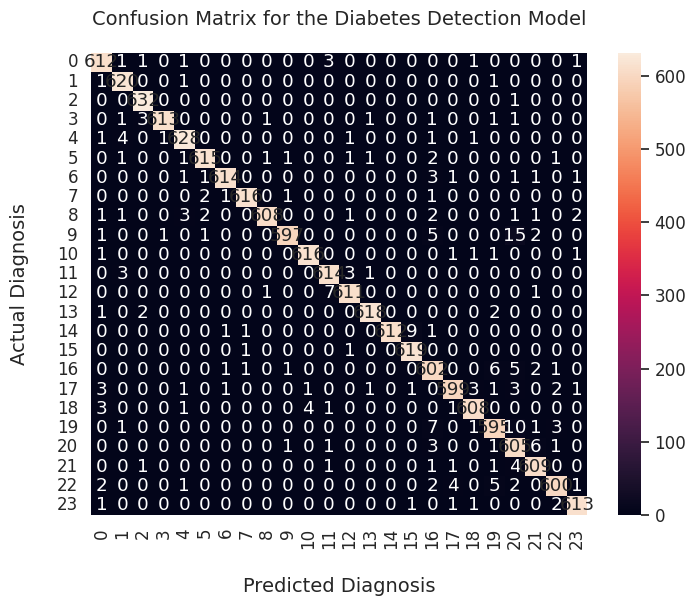

In [20]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [21]:
preds_val = model.predict(valid_generator)

233/233 [==============================] - 28s 120ms/step


In [22]:
evaluate_val = model.evaluate(valid_generator)

233/233 [==============================] - 27s 117ms/step - loss: 0.2028 - accuracy: 0.9878


In [23]:
evaluate_val

[0.20284588634967804, 0.9877786636352539]

In [24]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([ 0,  1,  0, ..., 23, 23, 23])

In [25]:
y_real_val = valid_generator.classes
y_real_val

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [26]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.986972871340317

In [27]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[614,   1,   2,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1, 617,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   2,   0,   0,   1,   0,   0,   0,   0],
       [  1,   1, 628,   0,   1,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   2, 611,   1,   0,   0,   0,   1,   1,   0,   0,   0,
          1,   0,   0,   1,   0,   0,   0,   1,   0,   0,   0],
       [  4,   3,   1,   0, 624,   0,   0,   0,   0,   0,   0,   1,   1,
          1,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 618,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   0,   0,   0,   1,   2,   0,   0],
       [  0,   0,   0,   0,   0,   0, 615,   4,   0,   0,   0,   0,   0,
          0,   0,   2,   0,   0,   0,   0,   2,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   3

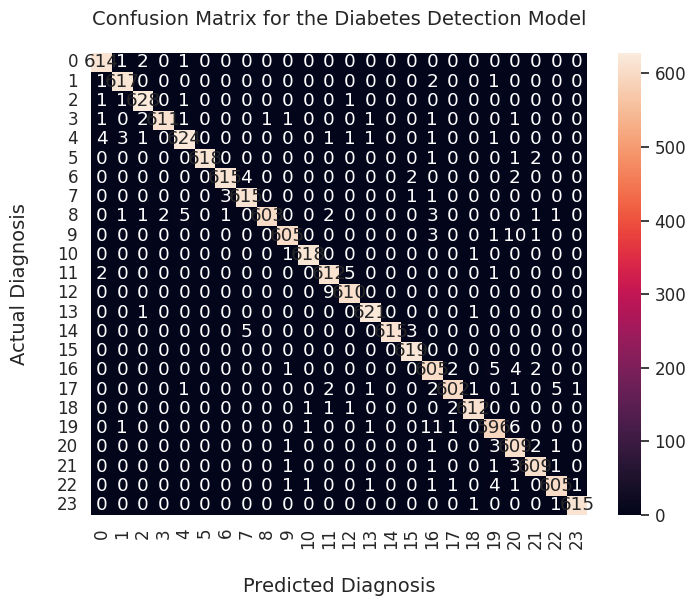

In [28]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()